# Stream Learning applied to 3W dataset

For more information about the theory behind this dataset, refer to the paper **A Realistic and Public Dataset with Rare Undesirable Real Events in Oil Wells** published in the **Journal of Petroleum Science and Engineering** (link [here](https://doi.org/10.1016/j.petrol.2019.106223)).

# 1. Introduction

This Jupyter Notebook fits the 3W dataset to models of the River package.

# 2. Imports and Configurations

In [276]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pathlib
import pickle
import graphviz
import river
from copy import deepcopy

from river import stream, feature_extraction as fx, compose, stats, preprocessing, tree, metrics, evaluate
from river import linear_model, optim, drift, anomaly, utils, ensemble, multiclass, datasets, time_series
from river import imblearn

import sklearn.model_selection
from sklearn.preprocessing import StandardScaler

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [264]:
river.__version__

'0.14.0'

# 3. Instances' Structure

Below, all 3W dataset's instances are loaded and the first one of each knowledge source (real, simulated and hand-drawn) is partially displayed.

In [265]:
class d3w():
    '''
    Class for managing Petrobras 3W dataset
    '''
    def __init__(self, path3w):
        self.path3w = path3w
        self.df = self.__load_df()
        return

    def __load_df(self):

        d = dict()
        d['origin'] = []
        d['well'] = []
        d['ts'] = []
        d['label'] = []
        d['path'] = []
        d['nlines'] = []
        for i in pathlib.Path(self.path3w).iterdir():
            if i.stem.isnumeric():
                print(i)
                label = int(i.stem)
                for fp in i.iterdir():
                    # Considers only csv files
                    if fp.suffix == ".csv":
                        d['well'].append(None)
                        d['ts'].append(None)
                        if (fp.stem.startswith("SIMULATED")):
                            d['origin'].append('S')
                        elif fp.stem.startswith("DRAWN"):
                            d['origin'].append('D')
                        else:
                            d['origin'].append('R')
                            if fp.stem.startswith('WELL'):
                                s = fp.stem
                                d['well'][-1] = int(s[5:10])
                                d['ts'][-1] = pd.Timestamp(year=int(s[11:15]), month=int(s[15:17]), day=int(s[17:19]), 
                                                           hour=int(s[19:21]), minute=int(s[21:23]), second=int(s[23:25]))
                        d['label'].append(label)
                        d['path'].append(fp)
                        d['nlines'].append(self.file_len(fp)-1)
                        
        return pd.DataFrame(d)
    
    def split(self, real=True, simul=True, drawn=True, well=None, test_size=0.2, val_size=0.1, sample_n=None):
        
        tmp0_df = self.get_df(real, simul, drawn, well)
        
        if sample_n is not None:
            N = len(tmp0_df.index)
            if N > sample_n:
                ds_list = []
                for i, ni in tmp0_df.groupby('label').count().nlines.items():
                    ns = ni*sample_n//N
                    ds_list.append(tmp0_df[tmp0_df.label == i].sample(n=ns, random_state=200560))
                tmp0_df = pd.concat(ds_list)            
        
        tmp_df, test_df = sklearn.model_selection.train_test_split(tmp0_df, 
                                                        test_size=test_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp0_df['label'])
        
        if val_size == 0:
            print('Instances Train: {}  Test: {}'.format(len(tmp_df.index), 
                                                         len(test_df.index)))
            return tmp_df.reset_index(drop=True),\
                   test_df.reset_index(drop=True)
        
        train_df, val_df = sklearn.model_selection.train_test_split(tmp_df, test_size=val_size, 
                                                        random_state=200560, 
                                                        shuffle=True, 
                                                        stratify=tmp_df['label'])
        print('Instances Train: {}  Test: {}  Validation: {}'.format(len(train_df.index), 
                                                                     len(test_df.index), 
                                                                     len(val_df.index)))
        
        return train_df.reset_index(drop=True),\
               test_df.reset_index(drop=True),\
               val_df.reset_index(drop=True)
    
    def file_len(self, filename):
        j = 0
        with open(filename) as f:
            for i, x in enumerate(f):
                if x.strip() == '':
                    j += 1
        return i + 1 - j
    
    def get_df(self, real=True, simul=True, drawn=True, well=None):
        if well is not None:
            return self.df[self.df['well']==well].drop(columns=['origin', 'well']).reset_index(drop=True)
        sel = []
        if real:
            sel.append('R')
        if simul:
            sel.append('S')
        if drawn:
            sel.append('D')
        if sel:
            return self.df[self.df['origin'].isin(sel)].drop(columns=['origin', 'well']).reset_index(drop=True)
    
    @property
    def all(self):
        return self.df.drop(columns=['origin'])
    @property
    def real(self):
        return self.df[self.df['origin']=='R'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def simul(self):
        return self.df[self.df['origin']=='S'].drop(columns=['origin']).reset_index(drop=True)
    @property
    def drawn(self):
        return self.df[self.df['origin']=='D'].drop(columns=['origin']).reset_index(drop=True)


In [266]:
if pathlib.Path('dset_tfm1.pkl').exists():
  with open('dset_tfm1.pkl', 'rb') as f:
    dset = pickle.load(f)
else:
    dset = d3w('../dataset')
    with open('dset_tfm1.pkl', 'wb') as f:
      pickle.dump(dset, f)

In [267]:
dset.all.groupby('label').path.count()

label
0    597
1    129
2     38
3    106
4    344
5    451
6    221
7     14
8     81
Name: path, dtype: int64

Subset of data for Well 1 and labels 0 (Normal conditions) and 4 (Flow instability).

In [268]:
flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
categories=[[0,1,2,3,4,5,6,7,8,101,102,103,104,105,106,107,108]]

data_df = dset.get_df()
data_df = data_df[data_df.label.isin([0, 2])]
data_df = data_df.sample(frac=1, random_state=200560).reset_index(drop=True)
data_df.groupby('label').path.count()

label
0    597
2     38
Name: path, dtype: int64

Each instance is stored in a CSV file and loaded into a pandas DataFrame. Each observation is stored in a line in the CSV file and loaded as a line in the pandas DataFrame. The first line of each CSV file contains a header with column identifiers. Each column of CSV files stores the following type of information:

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).

Other information are also loaded into each pandas Dataframe:

* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.  

            TYPE OF UNDESIRABLE EVENT       WINDOW SIZE   
		
            1 - ABRUPT INCREASE OF BSW       12h 
            2 – SPURIOUS CLOSURE OF DHSV     5min–20min 
            3 – SEVERE SLUGGING         	 5h 
            4 – FLOW INSTABILITY             15min 
            5 – RAPID PRODUCTIVITY LOSS 	 12h 
            6 – QUICK RESTRICTION IN PCK     15min 
            7 – SCALING IN PCK               72h 
            8 – HYDRATE IN PRODUCTION LINE   30min–5h 


In [269]:
class CustomGen():
    '''instance generator for the 3W files in dset'''
    
    def __init__(self, dset, flist, target, scaleb=False, out_time=False, ifileb=False, min_std=None):
        self.dset = dset
        self.flist = flist
        self.target = target
        self.scaleb = scaleb
        self.out_time = out_time
        self.ifileb = ifileb
        self.nfiles = len(dset.index)
        self.min_std = min_std
        return
    
    def todataframe(self):
        ds_list = []
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            #dfo = dfo[~dfo.index.duplicated(keep="first")].sort_index()

            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)

            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = np.nan
            
            ds['ifile'] = ifile
            
            ds_list.append(ds)
        return pd.concat(ds_list, ignore_index=True)
    
    def iter(self, max_n=None):
        n = 0
        for ifile, p in enumerate(self.dset['path']):
            dfo = pd.read_csv(p, index_col="timestamp", parse_dates=["timestamp"])
            #dfo = dfo[~dfo.index.duplicated(keep="first")].sort_index()

            if np.any(dfo[self.target].isna()):
                dfo[self.target] = dfo[self.target].fillna(method='ffill')
            dfo[self.target] = dfo[self.target].astype(int) #.apply(str)

            flist_ok = []
            flist_na = []
            for f in self.flist:
                nas = np.sum(dfo[f].isna())
                if nas > 0:
                    if nas < len(dfo.index) * 0.2:
                        dfo[f] = dfo[f].fillna(method='ffill')
                        flist_ok.append(f)
                    else:
                        flist_na.append(f)
                else:
                    flist_ok.append(f)

            fdict=dict()
            for f in flist_ok:
                fdict[f] = 'mean'

            def mode(series):
                return pd.Series.mode(series)[0]

            fdict[self.target] = [mode]

            dfo.reset_index(inplace=True)
            dfo['minute'] = dfo['timestamp'].dt.floor('Min')
            ds = dfo.groupby('minute').agg(fdict)
            ds.columns = ds.columns.droplevel(level=1)

            for f in flist_na:
                ds[f] = np.nan
            
            if self.scaleb:
                np.seterr(divide='ignore', invalid='ignore')
                dfd = self.scale(ds[self.flist]).to_dict(orient='records')
                np.seterr(divide='warn', invalid='warn')
            else:
                dfd = ds[self.flist].to_dict(orient='records')
            for i, x in enumerate(dfd):
                #assert isinstance(df.iloc[i][self.target], np.int32), 'class not an integer!'
                result = []
                if self.ifileb:
                    result.append(ifile)
                if self.out_time:
                    result.append(ds.index[i])
                yield result + [x, ds.iloc[i][self.target]]
                n += 1
                if max_n is not None and n > max_n:
                    break
            if max_n is not None and n > max_n:
                break

        return
    
    def scale(self, df):
        xm = df[self.flist].mean()
        sm = df[self.flist].std()
        if self.min_std is not None:
            sm = pd.concat([sm, pd.Series(self.min_std)]).groupby(level=0).max()[sm.index]
        return (df[self.flist]-xm)/sm

    def plot(self, ifiles):
        
        if isinstance(ifiles, list):
            n_files = len(ifiles)
        else:
            ifiles = [ifiles]
            n_files = 1
        
        fig, axs = plt.subplots(nrows=len(self.flist)+1, ncols=n_files, figsize=(10, 12), sharex='col')
        axs = axs.flatten()

        dss = []
        supt = ''
        for i_col, i_f in enumerate(ifiles):
        
            dss.append(pd.read_csv(self.dset['path'][i_f], parse_dates=["timestamp"]))
            #ds = ds.drop_duplicates(subset='timestamp', keep="last").sort_values(by=['timestamp']).reset_index(drop=True)
            if np.any(dss[i_col][self.target].isna()):
                ds[i_col][self.target] = ds[i_col][self.target].fillna(method='ffill')
            
            supt += str(self.dset['path'][i_f])
            if i_col != n_files-1:
                supt += '\n'
            fig.suptitle(supt)

            for i, vs in enumerate(self.flist):
                axs[i*n_files+i_col].plot(dss[i_col].timestamp[::60], dss[i_col][vs][::60])
                if i_col == 0:
                    axs[i*n_files+i_col].set_ylabel(vs)
        
            id = np.argsort(dss[i_col][self.target])
            t = [dss[i_col].timestamp[i] for i in id][::60]
            y = [str(dss[i_col][self.target][i]) for i in id][::60]
        
            axs[(i+1)*n_files+i_col].scatter(t, y, marker='.')
        
            axs[(i+1)*n_files+i_col].xaxis.set_tick_params(rotation=45)
            
            if i_col == 0:
                axs[(i+1)*n_files+i_col].set_ylabel(self.target)
        
            axs[(i+1)*n_files+i_col].set_xlabel('Date')
            
        
        for ax in axs.flatten():
            ax.grid(visible=True)

        return fig  


In [270]:
gen = CustomGen(data_df, flist, 'class', scaleb=True, out_time=True, ifileb=True)
n = 0
for i, time, x, t in gen.iter():
    if i == 3:
        print(i, time, x, t)
        n += 1
        if n > 3:
            break

3 2017-08-12 22:01:00 {'P-PDG': 1.5089853973065162, 'P-TPT': -0.9661674110630697, 'T-TPT': -0.2994468274735352, 'P-MON-CKP': -0.5927248552855218, 'T-JUS-CKP': nan, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2017-08-12 22:02:00 {'P-PDG': 1.4858194747853752, 'P-TPT': 0.6634400052302453, 'T-TPT': 1.0196923095380819, 'P-MON-CKP': -1.8620377591176325, 'T-JUS-CKP': nan, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2017-08-12 22:03:00 {'P-PDG': 1.4977702650998208, 'P-TPT': 0.8409896132523977, 'T-TPT': 0.6807211115558506, 'P-MON-CKP': -1.3827744532834754, 'T-JUS-CKP': nan, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0
3 2017-08-12 22:04:00 {'P-PDG': 1.529710493920819, 'P-TPT': 0.2542954689401597, 'T-TPT': 0.0030525653238654645, 'P-MON-CKP': -1.4040599996589933, 'T-JUS-CKP': nan, 'P-JUS-CKGL': nan, 'T-JUS-CKGL': nan, 'QGL': nan} 0.0


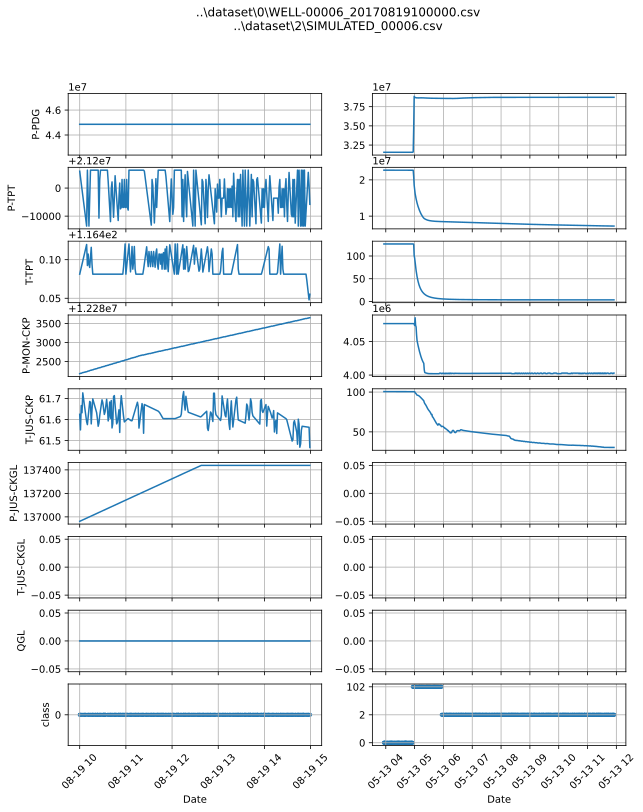

In [271]:
gen.plot([0,7])
plt.savefig('plot.jpg')

### Ajuste del Modelo  

Fit the subset to River models:
- A time window of 15min is used for calculating the rolling statistics:  
     mean, std, min, max  
  of every feature
- The standard scaler and the rolling statistics are reinitialized every new time series
- The fit starts after a warming period (equal to the rolling window size)

In [272]:
def fit_model(data_df, flist, target, window_size: int, model0, dfB=False, EvalB=False, n_epochs=1):
    '''Fit data_df 3W files to model0
       flist: features used by the model
       target: target used by the model
    '''
    if EvalB:
        model = model0
        n_epochs = 1
    else:
        model = deepcopy(model0)
    report0 = metrics.ClassificationReport()
    report = metrics.BalancedAccuracy()
    gen = CustomGen(data_df, flist, target, ifileb=True)
    scaler = preprocessing.StandardScaler()
    window_size = int(window_size)

    def func_reset(flist, window_size):
        fu = dict()
        for f in flist:
            fu[('rmean', f)] = utils.Rolling(stats.Mean(), window_size=window_size)
            fu[('rSEM', f)] = utils.Rolling(stats.SEM(ddof=1), window_size=window_size)
            fu[('rMax', f)] = stats.RollingMax(window_size=window_size)
            fu[('rMin', f)] = stats.RollingMin(window_size=window_size)
        return fu

    for n_epoch in range(n_epochs):
        if n_epochs > 1:
            print('\nepoch: ', n_epoch+1, '\n')
        ys = []
        y_preds = []
        accuracies = []
        ifiles = []
        lastfile = -1
        warm_start = window_size
        j = 0
        if dfB:
            df_list = []
        for i, (ifile, x, y) in enumerate(gen.iter(max_n=None)):
            if ifile != lastfile:
                print('\rfiles learned ', ifile+1, '/', gen.nfiles, end='')
                scaler = preprocessing.StandardScaler()
                fu = func_reset(flist, window_size)
                lastfile = ifile
                j = 0
            x = {k: v for k, v in x.items() if not np.isnan(v)}
            x = scaler.learn_one(x).transform_one(x)
            xd = dict()
            for ff, f in fu.keys():
                if f in x.keys():
                    xd[f+'_'+ff] = fu[(ff, f)].update(x[f]).get()
            j += 1
            if j >= warm_start:
                y_pred = model.predict_one(xd)
                if y_pred is None:
                    y_pred = 0
                    #print(i, ifile, x, y)
                report0 = report0.update(y, y_pred)
                report = report.update(y, y_pred)

                if not EvalB:
                    model.learn_one(xd, y)

                if dfB:
                    xd[target] = y
                    df_list.append(xd)
                ys.append(y)
                y_preds.append(y_pred)
                accuracies.append(report.get())
                ifiles.append(ifile)

        print('\n', report)
    print('\n', report0)
    if dfB:
        return ys, y_preds, accuracies, ifiles, model, pd.DataFrame(df_list)
    return ys, y_preds, accuracies, ifiles, model

In [286]:
%%time

#model =  tree.HoeffdingTreeClassifier(delta=1.E-4)
#model =  multiclass.OneVsOneClassifier(tree.HoeffdingTreeClassifier(delta=1.E-4))
#model =  multiclass.OneVsOneClassifier(linear_model.PAClassifier(C=1.0, mode=1))
#model = multiclass.OneVsOneClassifier(linear_model.ALMAClassifier())
model = imblearn.RandomOverSampler((tree.HoeffdingTreeClassifier(delta=1.E-4)),
        desired_dist={0: 0.4, 102: 0.2, 2: 0.4}, seed=200560)


flist = ['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'P-JUS-CKGL', 'T-JUS-CKGL', 'QGL']
window_size = 15

ys, y_preds, accuracies, ifiles, model_fitted, df = fit_model(data_df, flist, 'class', window_size,
                                                              model, dfB=True, EvalB=False, n_epochs=3)


epoch:  1 

files learned  635 / 635
 BalancedAccuracy: 94.71%

epoch:  2 

files learned  635 / 635
 BalancedAccuracy: 94.57%

epoch:  3 

files learned  635 / 635
 BalancedAccuracy: 94.32%

            Precision   Recall   F1       Support  
                                                  
     0.0      99.91%   98.83%   99.37%    478503  
     2.0      84.19%   98.79%   90.91%     18153  
   102.0      67.05%   85.33%   75.09%      7302  
                                                  
   Macro      83.71%   94.32%   88.46%            
   Micro      98.64%   98.64%   98.64%            
Weighted      98.86%   98.64%   98.71%            

                 98.64% accuracy                  
CPU times: total: 17min 12s
Wall time: 17min 13s


In [287]:
# Evaluación
yse, y_predse, accuraciese, _, _ = fit_model(data_df, flist, 'class', window_size, 
                                             model_fitted, dfB=False, EvalB=True)

files learned  635 / 635
 BalancedAccuracy: 89.79%

            Precision   Recall   F1       Support  
                                                  
     0.0      99.84%   99.33%   99.59%    159501  
     2.0      92.70%   96.13%   94.39%      6051  
   102.0      59.26%   73.91%   65.78%      2434  
                                                  
   Macro      83.93%   89.79%   86.58%            
   Micro      98.84%   98.84%   98.84%            
Weighted      99.00%   98.84%   98.91%            

                 98.84% accuracy                  


In [291]:
model_fitted.classifier.height

42

In [304]:
from sklearn.metrics import classification_report
#np.unique(y_preds, return_counts=True)
print(classification_report(yse, y_predse))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00    159501
         2.0       0.93      0.96      0.94      6051
       102.0       0.59      0.74      0.66      2434

    accuracy                           0.99    167986
   macro avg       0.84      0.90      0.87    167986
weighted avg       0.99      0.99      0.99    167986



In [294]:
%%time

# Variable Importance

from sklearn.ensemble import RandomForestClassifier

f_list = []
for f in df.columns:
    n = sum(df[f].isnull())
    print(f, n)
    if n == 0:
        f_list.append(f)
f_list = f_list[:-1]

forest = RandomForestClassifier(random_state=200560)
forest.fit(df[f_list], df['class'])
print('mean accuracy Random Forest: ', forest.score(df[f_list], df['class']))
varImp = {'var': f_list, 'varImp': forest.feature_importances_}
varImp = pd.DataFrame(varImp).sort_values(['varImp'], ascending=False)
print(varImp)

varImp = {'var': [x[0] for x in [x.split('_') for x in f_list]], 'varImp': forest.feature_importances_}
varImp = pd.DataFrame(varImp)
varImp = varImp.groupby('var').sum().sort_values(['varImp'], ascending=False).reset_index()
varImp

P-PDG_rmean 0
P-PDG_rSEM 0
P-PDG_rMax 0
P-PDG_rMin 0
P-TPT_rmean 0
P-TPT_rSEM 0
P-TPT_rMax 0
P-TPT_rMin 0
T-TPT_rmean 0
T-TPT_rSEM 0
T-TPT_rMax 0
T-TPT_rMin 0
P-MON-CKP_rmean 17726
P-MON-CKP_rSEM 17726
P-MON-CKP_rMax 17726
P-MON-CKP_rMin 17726
T-JUS-CKP_rmean 25487
T-JUS-CKP_rSEM 25487
T-JUS-CKP_rMax 25487
T-JUS-CKP_rMin 25487
P-JUS-CKGL_rmean 49764
P-JUS-CKGL_rSEM 49764
P-JUS-CKGL_rMax 49764
P-JUS-CKGL_rMin 49764
QGL_rmean 49476
QGL_rSEM 49476
QGL_rMax 49476
QGL_rMin 49476
class 0
mean accuracy Random Forest:  1.0
            var    varImp
3    P-PDG_rMin  0.199215
0   P-PDG_rmean  0.137651
6    P-TPT_rMax  0.127066
2    P-PDG_rMax  0.095961
9    T-TPT_rSEM  0.076772
5    P-TPT_rSEM  0.071496
4   P-TPT_rmean  0.067124
10   T-TPT_rMax  0.063186
1    P-PDG_rSEM  0.056775
11   T-TPT_rMin  0.041048
8   T-TPT_rmean  0.039452
7    P-TPT_rMin  0.024254
CPU times: total: 32.3 s
Wall time: 32.4 s


,var,varImp
0,P-PDG,0.489602
1,P-TPT,0.289941
2,T-TPT,0.220458


In [308]:
print(classification_report(df['class'], forest.predict((df[f_list]))))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    159501
         2.0       1.00      1.00      1.00      6051
       102.0       1.00      1.00      1.00      2434

    accuracy                           1.00    167986
   macro avg       1.00      1.00      1.00    167986
weighted avg       1.00      1.00      1.00    167986



In [245]:
def plot_acc(accuracies, accuraciesD, supt, subt):
    plt.figure(figsize=(10,4))

    plt.ylabel('Accuracies')
    plt.plot(accuracies, label='Predict/Fit')
    plt.plot(accuraciesD, label='Evaluated')
    plt.legend(loc="lower right")
    plt.title(supt + '\n' + subt)
    m, M = np.quantile(accuracies, [0.05, 0.95])
    m, M = round(m, 1), round(M+0.05, 1)    
    m1, M1 = np.quantile(accuraciesD, [0.05, 0.95])
    m1, M1 = round(m1, 1), round(M1+0.05, 1)    
    plt.ylim([min(m, m1), max(M, M1)])
    plt.grid()
    plt.show()
    return

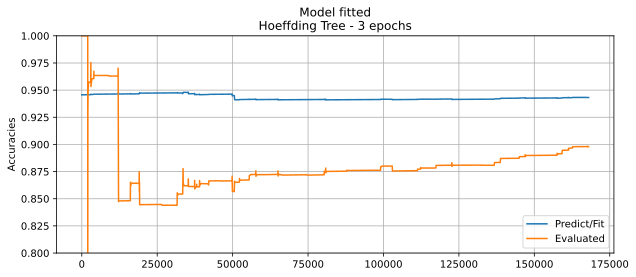

In [293]:
#plot_acc(accuracies, accuraciesD, 'Shuffle variables')
plot_acc(accuracies, accuraciese, 'Model fitted', 'Hoeffding Tree - 3 epochs')

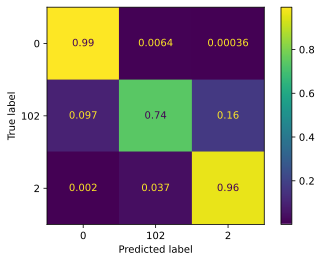

In [292]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

_ = ConfusionMatrixDisplay(confusion_matrix(yse, y_predse, labels=[0, 102, 2], normalize='true'), 
                       display_labels=[0, 102, 2]).plot()

## Drift test

In [295]:
class drift_reg:
    def __init__(self):
        self.d = {'i': [], 'n': [], 'ifile': [], 'label': [], 'y': [], 'path': [], 'warn': [], 
                  'change': [], 'origin': [], 'well': []}
        return
    def append(self, i, n, ifile, label, y, path, warn, change):
        self.d['i'].append(i)
        self.d['n'].append(n)
        self.d['ifile'].append(ifile)
        self.d['label'].append(label)
        self.d['y'].append(int(y))
        self.d['path'].append(path)
        self.d['warn'].append(warn)
        self.d['change'].append(change)
        self.d['well'].append(None)
        if (path.stem.startswith("SIMULATED")):
            self.d['origin'].append('S')
        elif path.stem.startswith("DRAWN"):
            self.d['origin'].append('D')
        else:
            self.d['origin'].append('R')
            if path.stem.startswith('WELL'):
                self.d['well'][-1] = int(path.stem[5:10])


        return
    def to_df(self):
        return pd.DataFrame(self.d)

In [305]:
dr = drift_reg()
lastfile = -1
for i, (ifile, er, y) in enumerate(zip(ifiles, np.not_equal(yse, y_predse), yse)):
    if ifile != lastfile:
        lastfile = ifile
        drd = drift.EDDM(warm_start=30, alpha=0.7, beta=0.6)
        #drd = drift.DDM(warm_start=30, warning_threshold=2, drift_threshold=3)
        #drd = drift.HDDM_A(drift_confidence=0.001, warning_confidence=0.005, two_sided_test=False)
        #drd = drift.HDDM_W(drift_confidence=0.001, warning_confidence=0.005, lambda_val=0.05, two_sided_test=False)
        print_warning = True
        n = 0
    _ = drd.update(er)
    warn = change = False
    if drd.warning_detected and print_warning:
        warn = True
        print(f"Warning detected at index {i} {n}, ifile {ifile}, label {data_df.iloc[ifile].label} {y} {data_df.iloc[ifile].path.stem}")
        print_warning = False
    if drd.drift_detected:
        change = True
        print(f"Change detected at index {i} {n}, ifile {ifile}, label {data_df.iloc[ifile].label} {y} {data_df.iloc[ifile].path.stem}")
        print_warning = True
    dr.append(i, n, ifile, data_df.iloc[ifile].label, y, data_df.iloc[ifile].path, warn, change)
    n += 1

res = dr.to_df()

Change detected at index 12079 119, ifile 44, label 2 102.0 WELL-00011_20140824000118
Change detected at index 19067 85, ifile 71, label 2 102.0 WELL-00011_20140606230115
Warning detected at index 19135 153, ifile 71, label 2 102.0 WELL-00011_20140606230115
Change detected at index 19140 158, ifile 71, label 2 102.0 WELL-00011_20140606230115
Change detected at index 26532 138, ifile 100, label 0 0.0 WELL-00005_20170516140007
Change detected at index 33604 168, ifile 126, label 2 102.0 WELL-00011_20140515110134
Change detected at index 35343 99, ifile 133, label 2 102.0 WELL-00003_20170728150240
Change detected at index 37440 121, ifile 142, label 2 2.0 SIMULATED_00010
Change detected at index 39078 122, ifile 148, label 2 2.0 SIMULATED_00015
Change detected at index 41880 174, ifile 157, label 0 0.0 WELL-00005_20170401120141
Change detected at index 45748 115, ifile 173, label 0 0.0 WELL-00005_20170812140000
Change detected at index 49869 97, ifile 189, label 2 102.0 WELL-00003_2014112

In [303]:
res.groupby(['origin', 'label', 'y', 'warn', 'change'])['path'].count() /\
            res.groupby(['origin', 'label', 'y'])['path'].count() * 100

origin  label  y    warn   change
R       0      0    False  False      99.993677
                           True        0.006323
        2      0    False  False      99.833887
                    True   False       0.166113
               2    False  False     100.000000
               102  False  False      99.525102
                           True        0.474898
S       2      0    False  False     100.000000
               2    False  False      99.895996
                           True        0.104004
               102  False  False     100.000000
Name: path, dtype: float64

In [298]:
res.groupby(['origin', 'warn', 'change'])['path'].count() /\
            res.groupby(['origin'])['path'].count() * 100

origin  warn   change
R       False  False     99.986917
               True       0.011837
        True   False      0.001246
S       False  False     99.919700
               True       0.080300
Name: path, dtype: float64

In [299]:
res.groupby(['label', 'warn', 'change'])['path'].count() /\
            res.groupby(['label'])['path'].count() * 100

label  warn   change
0      False  False     99.993677
              True       0.006323
2      False  False     99.827060
              True       0.152594
       True   False      0.020346
Name: path, dtype: float64

In [300]:
res.groupby(['y', 'warn', 'change'])['path'].count() /\
            res.groupby(['y'])['path'].count() * 100

y    warn   change
0    False  False     99.993103
            True       0.006897
2    False  False     99.851264
            True       0.115683
     True   False      0.033052
102  False  False     99.712408
            True       0.287592
Name: path, dtype: float64

In [301]:
res.groupby(['well', 'warn', 'change'])['path'].count() /\
            res.groupby(['well'])['path'].count() * 100

well  warn   change
1.0   False  False     100.000000
2.0   False  False     100.000000
3.0   False  False      99.961054
             True        0.038946
4.0   False  False     100.000000
5.0   False  False      99.947513
             True        0.052487
6.0   False  False     100.000000
7.0   False  False     100.000000
8.0   False  False      99.987548
             True        0.012452
9.0   False  False     100.000000
10.0  False  False     100.000000
11.0  False  False      99.602912
             True        0.330907
      True   False       0.066181
12.0  False  False     100.000000
13.0  False  False      98.692810
             True        0.653595
      True   False       0.653595
Name: path, dtype: float64